In [45]:
import numpy as np 
import pandas as pd
import requests
import PyPDF2
from urllib.parse import urlparse
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
import fitz
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from helper import *
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

In [46]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/arpanmukhopadhyay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arpanmukhopadhyay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/arpanmukhopadhyay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
df = pd.read_csv('data.csv')
df.head

<bound method NDFrame.head of                                                  Name  \
0   Recent advances in ammonia synthesis technolog...   
1   Co doping regulating electronic structure of B...   
2   A Prompt Decarbonization Pathway for Shipping:...   
3   Utilization of green ammonia as a hydrogen ene...   
4   Defective TiO2-x for High-Performance Electroc...   
..                                                ...   
77  A comprehensive study of renewable energy sour...   
78  Data-driven probabilistic machine learning in ...   
79  Semi-supervised adversarial discriminative lea...   
80  Model Predictive Current Control of Nine-Phase...   
81  Risk-constrained stochastic scheduling for ene...   

                                                 DOI  
0   http://dx.doi.org/10.1016/j.ijhydene.2022.09.061  
1     http://dx.doi.org/10.1016/j.apcatb.2023.123057  
2            http://dx.doi.org/10.3390/atmos14030584  
3   http://dx.doi.org/10.1016/j.ijhydene.2023.04.073  
4         

In [48]:
def extract_abstract(pdf_path):
    doc = fitz.open(pdf_path)
    
    text = ""
    for page_num in range(3): 
        page = doc.load_page(page_num)
        text += page.get_text()
    
    abstract_start = re.search(r'abstract|A B S T R A C T|ABSTRACT|Iodide redox|Discovery of|Water electrolysis', text, re.IGNORECASE)
    if not abstract_start:
        return None
    
    start_index = abstract_start.end()
    end_markers = [r'©',r'\x01',r'\*', r'\b Index Terms:', r'\b1\.\s*Introduction\b', r'\bIntroduction\b','\bNomenclature\b']
    end_index = len(text)
    
    for marker in end_markers:
        match = re.search(marker, text[start_index:], re.IGNORECASE)
        if match:
            end_index = min(end_index, start_index + match.start())
    
    abstract = text[start_index:end_index].strip()
    abstract = re.sub(r'\s+', ' ', abstract)
    
    if len(abstract)> 1:
        return abstract
    else:
        return None

In [49]:
# extract_abstract('data/1-s2.0-S0020025523010812-main.pdf')
extract_abstract('data/1-s2.0-S0360319922061481-main.pdf')

'Green ammonia Green hydrogen Seawater desalination a b s t r a c t This paper presents a comprehensive technical and economic assessment of potential green hydrogen and ammonia production plants in different locations in Iran with strong wind and solar resources. The study was organized in ﬁve steps. First, regarding the wind density and solar PV potential data, three locations in Iran were chosen with the highest wind power, solar radiation, and a combination of both wind/solar energy. All these lo- cations are inland spots, but since the produced ammonia is planned to be exported, it must be transported to the export harbor in the South of Iran. For comparison, a base case was also considered next to the export harbor with normal solar and wind potential, but no distance from the export harbor. In the second step, a similar large-scale hydrogen pro- duction facility with proton exchange membrane electrolyzers was modeled for all these locations using the HOMER Pro simulation platfor

In [50]:
# def get_pdf_info(filepath):
#     with open(filepath, 'rb') as f:
#         reader = PyPDF2.PdfFileReader(f, strict=False)
#         if reader.isEncrypted:
#             try:
#                 reader.decrypt('')
#             except:
#                 return None 
#         info = reader.getDocumentInfo()
#         return info
        # if info is not None:
        #     title = info['/doi']
        #     return title if title is not None else None
        # return None

# get_pdf_title('data/1-s2.0-S1342937X2300076X-main.pdf')

In [51]:
def get_pdf_title(filepath):
    with open(filepath, 'rb') as f:
        reader = PyPDF2.PdfFileReader(f, strict=False)
        if reader.isEncrypted:
            try:
                reader.decrypt('')
            except:
                return None 
        info = reader.getDocumentInfo()
        if info is not None:
            title = info.title
            return title if title is not None else None
        return None

def normalise_name(s):
    s = str(s)
    s = re.sub(r'[\s:"\'\-_&#x2013;\u2010-\u2015\u201C-\u201F\u2018-\u201B&nbsp;]', '', s)
    s = s.lower()  
    return s

df['Abstract'] = None
def extract_all_abstracts(directory_path):
    abstracts = {}
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        file_name = get_pdf_title(file_path)
        file_name_normal = normalise_name(file_name)
        for n in df['Name']:
            base = normalise_name(n)
            if base == file_name_normal:
                name = n
                break
        abstract = extract_abstract(file_path)
        if abstract:
            df.loc[df['Name'] == name, 'Abstract'] = abstract
        else:
            abstracts[filename] = None
    return abstracts

# print(normalise_name("The economics of global green ammonia trade – “Shipping Australian wind and sunshine to Germany”"))
abstract_text = extract_all_abstracts('data')
# # print (abstract_text)

#Recent Progress in Rechargeable Sodium‐Ion Batteries: toward High‐Power Applications
#Recent Progress in Rechargeable Sodium-Ion Batteries: toward High-Power Applications

In [52]:
print(df['Abstract'].value_counts())

Abstract
Photovoltaic (PV) technology, as a low-carbon energy technology, is crucial to mitigating climate change and achieving sustainable development. China has the largest total number of PV technology patents in the world, but the lack of core technologies has restricted the further innovative development of China’s PV industry. Therefore, it is necessary to clarify China’s current PV technology accumulation to better catch up with key technology areas. To clearly describe the structural characteristics of China’s PV technology innovation network, this study uses China’s patent PV technology data over the past 20 years from the Incopat global patent database and analyses the structural characteristics of the network from the perspectives of one-mode and two-mode networks, using method of social network analysis (SNA). The results show that 1) the leading PV enterprises have basically formed relatively stable internal collaborations and that the scale of innovation network devel­ op

In [53]:
new_df = df[['Name','Abstract']]

In [54]:
new_df = new_df.dropna(subset=['Abstract'])
new_df = new_df.reset_index(drop=True)
new_df

,Name,Abstract
0,Recent advances in ammonia synthesis technolog...,"As a carbon-free molecule, ammonia has gained ..."
1,Co doping regulating electronic structure of B...,Although photocatalytic nitrogen reduction rea...
2,A Prompt Decarbonization Pathway for Shipping:...,: The shipping industry has reached a higher l...
3,Utilization of green ammonia as a hydrogen ene...,Rising concerns about the dependence of modern...
4,Techno-economic assessment of green hydrogen a...,Green ammonia Green hydrogen Seawater desalina...
...,...,...
68,A comprehensive study of renewable energy sour...,Renewable energy (RE) is the key element of su...
69,Data-driven probabilistic machine learning in ...,The current trend indicates that energy demand...
70,Semi-supervised adversarial discriminative lea...,Keywords: Wind turbine Data-driven Intelligent...
71,Model Predictive Current Control of Nine-Phase...,—The current error is hard to avoid for ﬁnite ...


In [55]:
def preprocess_text(text):
    if pd.isna(text):
        return None
    
    text = text.lower()
    text = re.sub(r'[/\-]', ' ', text)
    text = re.sub(r'abstract',' ',text)
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\b(?!\d{4}\b)\d+\b', '', text)
    text = re.sub(r'[^\w\s\[\]]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    
    tokens = [token for token in tokens if token not in stop_words]
    
    processed_tokens = [stemmer.stem(lemmatizer.lemmatize(token)) for token in tokens]
    
    return ' '.join(processed_tokens)

In [56]:
new_df['processed_abstract'] = new_df['Abstract'].apply(preprocess_text)

In [57]:
new_df.iloc[3]['processed_abstract']

'rise concern depend modern energi system fossil fuel rais requir green altern fuel pave roadmap sustain energi futur carbon free economi massiv expect hydrogen enabl decarbon energi sector limit lack requir infrastructur whose implement affect issu relat storag distribut hydrogen energi ammonia effect hydrogen energi carrier well establish matur infrastructur long distanc transport distribut possi biliti green ammonia product renew energi sourc made suitabl green altern fuel decarbon automot power gener sector work engin characterist ammonia combust spark ignit engin report detail note engin fuell pure ammonia well blend ammonia gasolin hydrogen methan higher auto ignit temperatur low ﬂammabl lower ﬂame speed ammonia detriment effect engin characterist could address either incorpor engin modiﬁc enhanc fuel qualiti literatur show increas compress ratio improv maximum power addit hydrogen supercharg condit improv indic efﬁcienc challeng strategi util ammonia combust fuel en gine discuss

In [58]:
clean_df = new_df.drop_duplicates()
clean_df

,Name,Abstract,processed_abstract
0,Recent advances in ammonia synthesis technolog...,"As a carbon-free molecule, ammonia has gained ...",carbon free molecul ammonia gain great global ...
1,Co doping regulating electronic structure of B...,Although photocatalytic nitrogen reduction rea...,although photocatalyt nitrogen reduct reaction...
2,A Prompt Decarbonization Pathway for Shipping:...,: The shipping industry has reached a higher l...,ship industri reach higher level matur term kn...
3,Utilization of green ammonia as a hydrogen ene...,Rising concerns about the dependence of modern...,rise concern depend modern energi system fossi...
4,Techno-economic assessment of green hydrogen a...,Green ammonia Green hydrogen Seawater desalina...,green ammonia green hydrogen seawat desalin b ...
...,...,...,...
68,A comprehensive study of renewable energy sour...,Renewable energy (RE) is the key element of su...,renew energi key element sustain environment f...
69,Data-driven probabilistic machine learning in ...,The current trend indicates that energy demand...,current trend indic energi demand suppli event...
70,Semi-supervised adversarial discriminative lea...,Keywords: Wind turbine Data-driven Intelligent...,keyword wind turbin data driven intellig diagn...
71,Model Predictive Current Control of Nine-Phase...,—The current error is hard to avoid for ﬁnite ...,current error hard avoid ﬁnite control set mod...


In [59]:
def vectorize_texts(texts):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    return vectors,feature_names

In [60]:
vectors,feature_names = vectorize_texts(clean_df['processed_abstract'])
print(vectors.shape)

(71, 2684)


In [61]:
pca = PCA(n_components=2) 
reduced_vectors = pca.fit_transform(vectors.toarray())

[1 2 3]


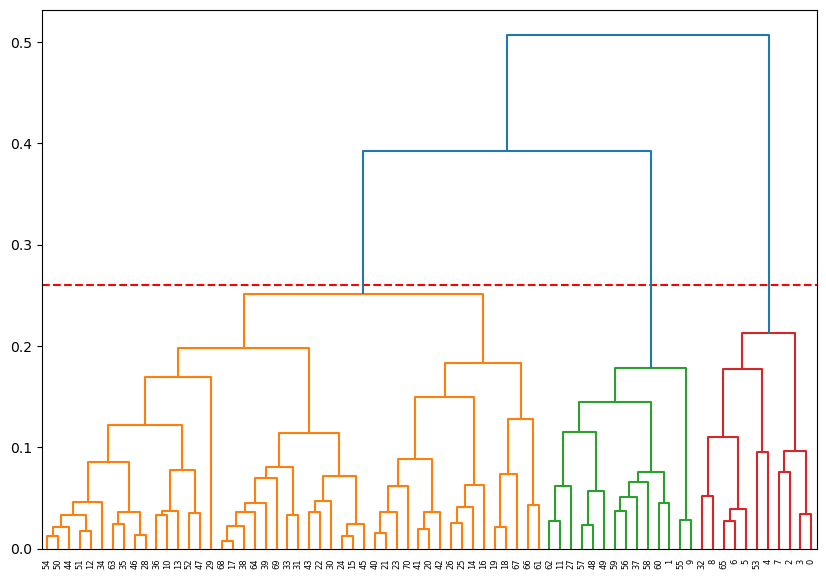

In [62]:
Z = linkage(reduced_vectors, method='average')
max_d = 0.26
clusters = fcluster(Z, max_d, criterion='distance')
print(np.unique(clusters)) 

plt.figure(figsize=(10, 7))
plt.axhline(y=max_d, color='r', linestyle='--')
dendrogram(Z, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

In [63]:
silhouette_avg = silhouette_score(reduced_vectors, clusters)
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5255524150838181


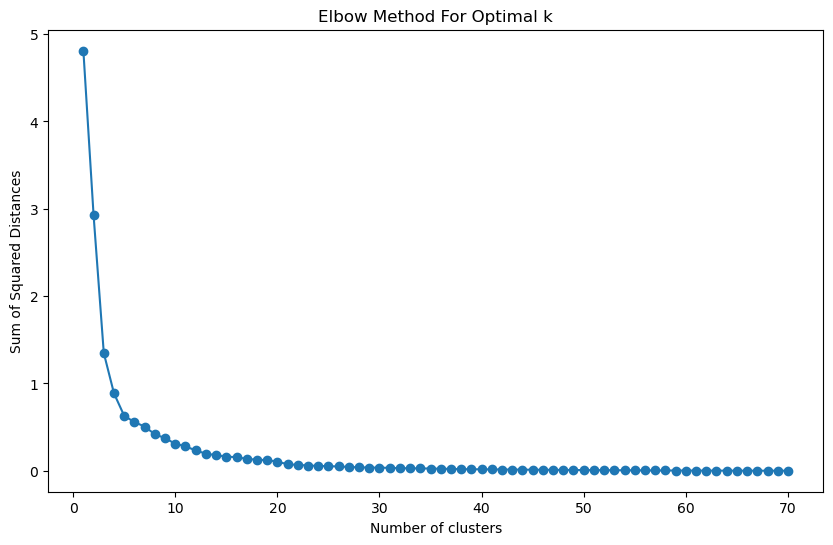

In [64]:
def find_optimal_clusters(data, max_k):
    i = range(1, max_k + 1)
    sse = []
    
    for k in i:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
        
    plt.figure(figsize=(10, 6))
    plt.plot(i, sse, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

find_optimal_clusters(reduced_vectors, 70)

In [65]:
def silhouette_method(data, max_k):
    iters = range(2, max_k + 1)
    silhouette_scores = []
    
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        silhouette_scores.append(score)
        
    plt.figure(figsize=(10, 6))
    plt.plot(iters, silhouette_scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method For Optimal k')
    plt.show()

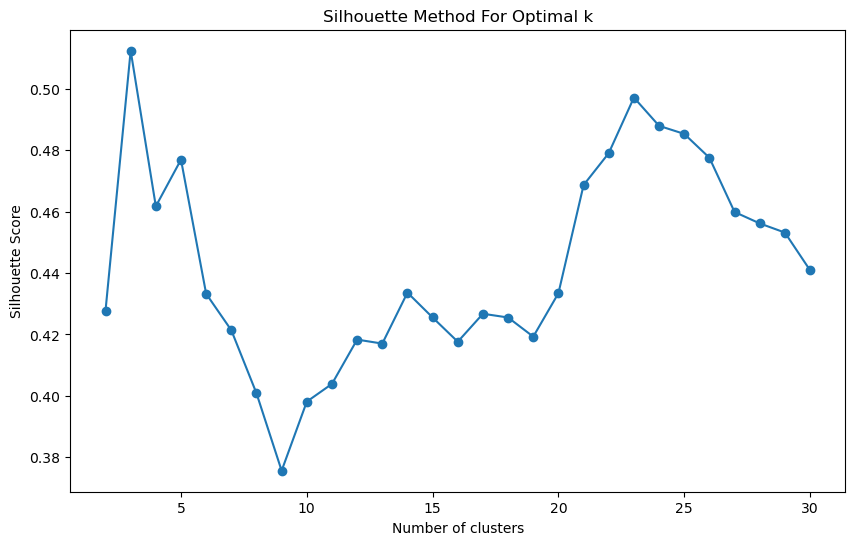

In [66]:
silhouette_method(reduced_vectors, 30)

In [67]:
def k_means(optimal_k):
    km = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    km.fit(reduced_vectors)
    sil_score = silhouette_score(reduced_vectors, km.labels_)
    db_score = davies_bouldin_score(reduced_vectors, km.labels_)
    clean_df.loc[:, 'cluster'] = km.labels_
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=km.labels_, cmap='viridis')
    plt.title(f'k-means Clusters (k={optimal_k})')
    plt.colorbar(scatter)
    plt.show()
    return sil_score, db_score

/var/folders/s6/rv1s577j2fz5f0c8jfpj17dw0000gn/T/ipykernel_12165/3727724418.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df.loc[:, 'cluster'] = km.labels_


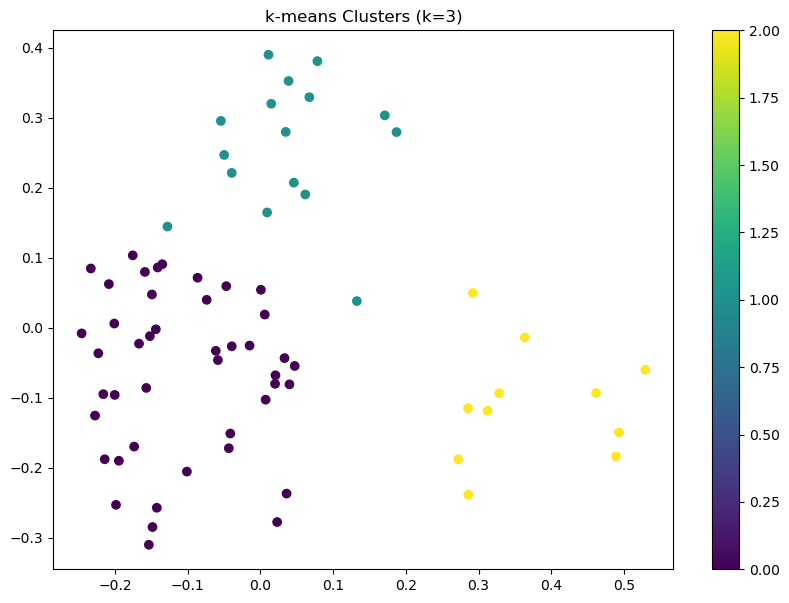

Silhouette Score for k=3: 0.51
DB score for k=3: 0.64


In [68]:
optimal_k = 3
silhouette_score, db_score = k_means(optimal_k)
print(f'Silhouette Score for k={optimal_k}: {silhouette_score:.2f}')
print(f'DB score for k={optimal_k}: {db_score:.2f}')

In [69]:
clean_df

,Name,Abstract,processed_abstract,cluster
0,Recent advances in ammonia synthesis technolog...,"As a carbon-free molecule, ammonia has gained ...",carbon free molecul ammonia gain great global ...,2
1,Co doping regulating electronic structure of B...,Although photocatalytic nitrogen reduction rea...,although photocatalyt nitrogen reduct reaction...,1
2,A Prompt Decarbonization Pathway for Shipping:...,: The shipping industry has reached a higher l...,ship industri reach higher level matur term kn...,2
3,Utilization of green ammonia as a hydrogen ene...,Rising concerns about the dependence of modern...,rise concern depend modern energi system fossi...,2
4,Techno-economic assessment of green hydrogen a...,Green ammonia Green hydrogen Seawater desalina...,green ammonia green hydrogen seawat desalin b ...,2
...,...,...,...,...
68,A comprehensive study of renewable energy sour...,Renewable energy (RE) is the key element of su...,renew energi key element sustain environment f...,0
69,Data-driven probabilistic machine learning in ...,The current trend indicates that energy demand...,current trend indic energi demand suppli event...,0
70,Semi-supervised adversarial discriminative lea...,Keywords: Wind turbine Data-driven Intelligent...,keyword wind turbin data driven intellig diagn...,0
71,Model Predictive Current Control of Nine-Phase...,—The current error is hard to avoid for ﬁnite ...,current error hard avoid ﬁnite control set mod...,1


In [70]:
clean_df.to_csv('clustering_results.csv', index=False)

In [71]:
def generate_report(optimal_k, clean_df, n_terms, feature_names):
    cluster_terms = {}
    for cluster_num in range(optimal_k):
        cluster_indices = np.where(clean_df['cluster'] == cluster_num)[0]
        cluster_tfidf_sum = np.asarray(vectors[cluster_indices].sum(axis=0)).flatten()
        top_terms_indices = np.argsort(cluster_tfidf_sum)[::-1][:n_terms]
        top_terms = [feature_names[i] for i in top_terms_indices]
        cluster_terms[cluster_num] = top_terms

    papers_in_cluster = clean_df['cluster'].value_counts().sort_index()
    print(f'No. clusters: {optimal_k}')

    print(f'No. clusters: {optimal_k}')
    summary_report = f'No. Clusters: {optimal_k}\n\n'

    summary_report += 'No. papers per cluster:\n'
    summary_report += papers_in_cluster.to_string() + '\n\n'
    print(f'No. papers per cluster: {papers_in_cluster}')
    summary_report += f'Top {n_terms} in each cluster:\n'
    print(f'Top {n_terms} terms in each cluster')
    for cluster_num, terms in cluster_terms.items():
        print(f'Cluster {cluster_num}: {", ".join(terms)}')
        summary_report += f'Cluster {cluster_num}: {", ".join(terms)}\n'

    with open('summary.txt', 'w') as file:
        file.write(summary_report)

In [72]:
generate_report(optimal_k, clean_df, 10, feature_names)

No. clusters: 3
No. clusters: 3
No. papers per cluster: cluster
0    44
1    16
2    11
Name: count, dtype: int64
Top 10 terms in each cluster
Cluster 0: energi, system, solar, power, grid, electr, pv, batteri, wind, gener
Cluster 1: reaction, electrod, catalyst, hydrogen, activ, electrolysi, product, materi, nanoparticl, water
Cluster 2: ammonia, hydrogen, green, fuel, energi, product, cost, sourc, use, methanol
